## 30 - Basic Radar Plotting Part 2

Watch video: [YouTube](https://www.youtube.com/watch?v=fSax8g9EfxM)

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.plots as mpplots
from metpy.plots import ctables
from siphon.catalog import TDSCatalog
from siphon.radarserver import RadarServer
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
cat = TDSCatalog('https://thredds.ucar.edu/thredds/radarServer/catalog.xml')
url = cat.catalog_refs['NEXRAD Level III Radar from IDD'].href
rs = RadarServer(url)

In [3]:
start = datetime.datetime.utcnow() - datetime.timedelta(hours=1)
end = datetime.datetime.utcnow()
query = rs.query()
query.stations('FTG')
query.time_range(start, end)
query.variables('N0C')

var=N0C&time_start=2024-03-25T02%3A09%3A25.788157&time_end=2024-03-25T03%3A09%3A25.788157&stn=FTG

In [4]:
query_cat = rs.get_catalog(query)
data = query_cat.datasets[0].remote_access()
list(data.variables)

['elevation',
 'azimuth',
 'gate',
 'latitude',
 'longitude',
 'altitude',
 'rays_time',
 'CorrelationCoefficient_RAW',
 'CorrelationCoefficient']

In [5]:
field_name = 'CorrelationCoefficient'
range_data = data.variables['gate'][:]
azimuth_data = data.variables['azimuth'][:]
radar_data = data.variables[field_name][:]

In [6]:
x = range_data * np.sin(np.deg2rad(azimuth_data))[:, np.newaxis]
y = range_data * np.cos(np.deg2rad(azimuth_data))[:, np.newaxis]

In [7]:
radar_data = np.ma.array(radar_data, mask=np.isnan(radar_data))
proj = ccrs.LambertConformal(central_longitude=data.RadarLongitude, central_latitude=data.RadarLatitude)

In [8]:
print(data.time_coverage_start)
data_time = datetime.datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%SZ')
print(data_time)

2024-03-25T03:03:45Z
2024-03-25 03:03:45


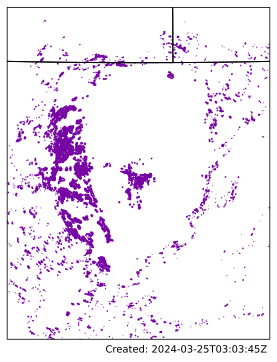

In [9]:
fig = plt.figure(1, figsize=(8, 6))
ax = plt.subplot(projection=proj)
norm, cmap = ctables.registry.get_with_steps('Carbone42', 16, 16)
mesh = ax.contour(x, y, radar_data, norm=norm, cmap=cmap, zorder=0)
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=1, zorder=1)
mpplots.add_timestamp(ax, time=data_time)
distance_in_degrees = 1.8
ax.set_extent([data.RadarLongitude - distance_in_degrees, data.RadarLongitude + distance_in_degrees, 
               data.RadarLatitude - distance_in_degrees, data.RadarLatitude + distance_in_degrees])
plt.show()